In [1]:
#import some basic libraries
import pandas as pd
import numpy as np
  
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import os
import cv2

After having a look at the extracted files in the folder, we have 4 lables namely - Covid, Viral Pneumonia, Normal, Lung Opacity. But for detection of covid, we just need 2 lables - Covid & Normal. Other 2 we won't be needing. And we need only images folder, not masks.

In [2]:
#defining a function to read all the images from required folders
def read_images(root_dir, size):
    x=[]
    y=[]
    folder_names = os.listdir(root_dir)
    for folder_name in folder_names:
        file_names = os.listdir(f'{root_dir}/{folder_name}')
        
        for file_name in file_names:
            if 'jpg' or 'JPG' or 'JPEG' or 'jpeg' or 'png' or 'PNG' in filename:
                img = cv2.imread(f'{root_dir}/{folder_name}/{file_name}')
                if img is None:
                    continue
                img = cv2.resize(img, size, interpolation=cv2.INTER_NEAREST)
                x.append(img)
                y.append(folder_name)
                
    return (x,y)

In [3]:
#loading all images with pre_defined function and loading foldernames as labels
root_dir = 'Data/Covid_detect'
size = (250,250)
x, y = read_images(root_dir, size)

In [4]:
#converting x into numpy array

x = np.array(x)

x.shape

(13808, 250, 250, 3)

### Label Encoding

In [5]:
#convert the y into numpy array by label encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y = le.fit_transform(y)

In [6]:
y.shape

(13808,)

In [7]:
#let us find the unique values and labels of y
np.unique(y)

array([0, 1])

In [8]:
le.classes_

array(['covid', 'normal'], dtype='<U6')

So we have Covid=0 & Normal=1 in our dataset.

### Data Visualisation

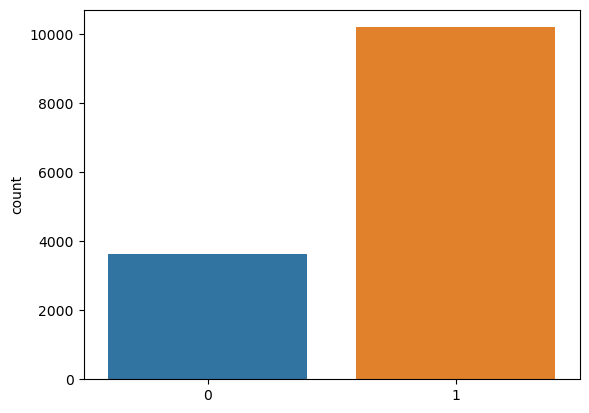

In [9]:
import seaborn as sns

sns.countplot(y)
plt.show()

We have more than double for Normal(1) than Covid(0). This dataset is imbalanced.

- Let us do image detection with Imbalanced Dataset first and then compare its accuracy with Undersampling and oversampling Models. And then we can go with Transfer learning Models with balanced Dataset.

In [10]:
#let us make the copy of dataset (for just in case scenarios)
x1 = x.copy()
y1 = y.copy()

### Splitting the Data

In [11]:
#let us split the train data into test and train
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.25,random_state = 42)

In [12]:
x_train.shape, y_train.shape

((10356, 250, 250, 3), (10356,))

In [13]:
x_test.shape, y_test.shape

((3452, 250, 250, 3), (3452,))


### Building the Model

In [14]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

2023-05-15 21:33:08.468411: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
model_im = Sequential()

model_im.add(Conv2D(64, (3,3), activation='relu', input_shape=(250,250,3)))
model_im.add(MaxPooling2D((2,2)))

model_im.add(Conv2D(32, (3,3), activation='relu'))
model_im.add(MaxPooling2D((2,2)))

model_im.add(Flatten())
model_im.add(Dense(500, activation='relu'))
model_im.add(Dropout(0.2))
model_im.add(Dense(250, activation='relu'))
model_im.add(Dropout(0.2))
model_im.add(Dense(100, activation='relu'))

model_im.add(Dense(1, activation='sigmoid'))

In [16]:
model_im.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 119072)            0         
                                                                 
 dense (Dense)               (None, 500)               5

### Compile & Fit the Model

In [17]:
model_im.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', min_delta=0.005, patience=2, mode='auto')

history_1 = model_im.fit(x_train, y_train, epochs=10, validation_split=0.20, batch_size=64, callbacks=[es])

Epoch 1/10
130/130 [==============================] - 1135s 9s/step - loss: 5.0939 - accuracy: 0.7814 - val_loss: 0.3412 - val_accuracy: 0.8263
Epoch 2/10
130/130 [==============================] - 1139s 9s/step - loss: 0.3068 - accuracy: 0.8617 - val_loss: 0.3227 - val_accuracy: 0.8422
Epoch 3/10
130/130 [==============================] - 1066s 8s/step - loss: 0.2315 - accuracy: 0.8952 - val_loss: 0.3421 - val_accuracy: 0.8576
Epoch 4/10
130/130 [==============================] - 1047s 8s/step - loss: 0.1820 - accuracy: 0.9259 - val_loss: 0.3934 - val_accuracy: 0.8605
Epoch 5/10
130/130 [==============================] - 1419s 11s/step - loss: 0.1378 - accuracy: 0.9446 - val_loss: 0.4396 - val_accuracy: 0.8653
Epoch 6/10
130/130 [==============================] - 1099s 8s/step - loss: 0.1338 - accuracy: 0.9436 - val_loss: 0.4986 - val_accuracy: 0.8818
Epoch 7/10
130/130 [==============================] - 1072s 8s/step - loss: 0.0960 - accuracy: 0.9634 - val_loss: 0.6504 - val_accuracy

### Evaluate on Test Data

In [19]:
#Evaluating the model
test_loss_im, test_acc_im = model_im.evaluate(x_test,  y_test, verbose=2)
print('Test loss with Imbalanced Data is ',test_loss_im)
print('Test Accuracy with Imbalanced Data is ',test_acc_im)

108/108 - 110s - loss: 0.5822 - accuracy: 0.8705 - 110s/epoch - 1s/step
Test loss with Imbalanced Data is  0.582217276096344
Test Accuracy with Imbalanced Data is  0.8705098628997803


Text(0.5, 1.0, 'Train - Accuracy')

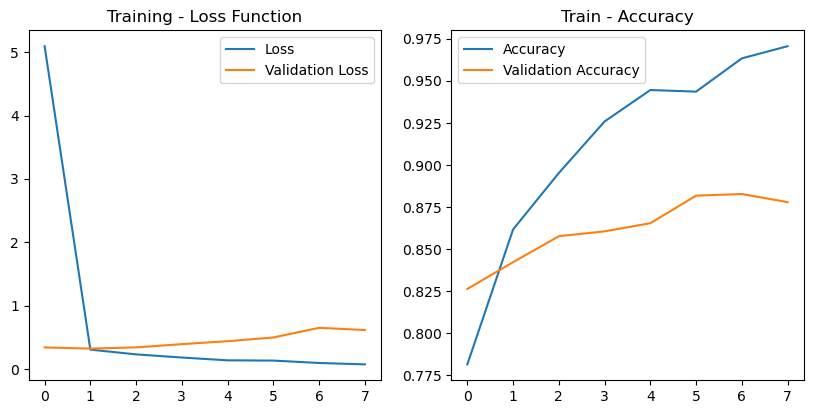

In [20]:
#Let us plot the Training Accuracy vs Loss to get a better understanding of the model training.

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history_1.history['loss'], label='Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history_1.history['accuracy'], label='Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

### Under-Sampling

Undersampling is a useful way to balance imbalanced datasets.

In [21]:
# under sampling

from imblearn.under_sampling import NearMiss

x_us = x.reshape(x.shape[0], -1)  # flatten each image to a 1D array

near_miss = NearMiss()

x_us, y_us = near_miss.fit_resample(x_us, y)

In [22]:
x_us.shape , x.shape

((7232, 187500), (13808, 250, 250, 3))

In [23]:
#deflatten each image back to its original form

# Assume original shape of each image is (height, width, channels)
height, width, channels = 250, 250, 3

# Reshape flattened data back to original shape
x_us = x_us.reshape(-1, height, width, channels)

# Print the new shape of x_us
print("New shape of x_us:", x_us.shape)


New shape of x_us: (7232, 250, 250, 3)


In [24]:
y_us.shape

(7232,)

In [25]:
unique_values, counts = np.unique(y_us, return_counts=True)
print("Unique values:", unique_values)
print("Counts:", counts)

Unique values: [0 1]
Counts: [3616 3616]


Now the label count is same. And both x and y are of same shape too

### Splitting the Data

In [26]:
#let us split the train data into test and train
from sklearn.model_selection import train_test_split

x_train1,x_test1,y_train1,y_test1 = train_test_split(x_us,y_us,test_size = 0.25,random_state = 42)

In [27]:
x_train1.shape, x_test1.shape

((5424, 250, 250, 3), (1808, 250, 250, 3))

In [28]:
y_train1.shape, y_test1.shape 

((5424,), (1808,))

### Defining the Model

In [29]:
model_us = Sequential()

model_us.add(Conv2D(64, (3,3), activation='relu', input_shape=(250,250,3)))
model_us.add(MaxPooling2D((2,2)))

model_us.add(Conv2D(32, (3,3), activation='relu'))
model_us.add(MaxPooling2D((2,2)))

model_us.add(Flatten())
model_us.add(Dense(250, activation='relu'))
model_us.add(Dropout(0.2))
model_us.add(Dense(100, activation='relu'))

model_us.add(Dense(1, activation='sigmoid'))

In [30]:
model_us.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 248, 248, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 124, 124, 64)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 122, 122, 32)      18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 119072)            0         
                                                                 
 dense_4 (Dense)             (None, 250)              

### Compile & fit the model

In [31]:
model_us.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', min_delta=0.005, patience=2, mode='auto')

history_2 = model_us.fit(x_train1, y_train1, epochs=10, validation_split=0.20, batch_size=64, callbacks=[es])

Epoch 1/10
68/68 [==============================] - 542s 8s/step - loss: 33.3683 - accuracy: 0.6979 - val_loss: 0.4353 - val_accuracy: 0.8083
Epoch 2/10
68/68 [==============================] - 576s 8s/step - loss: 0.3861 - accuracy: 0.8341 - val_loss: 0.3473 - val_accuracy: 0.8369
Epoch 3/10
68/68 [==============================] - 553s 8s/step - loss: 0.2487 - accuracy: 0.8997 - val_loss: 0.4205 - val_accuracy: 0.8470
Epoch 4/10
68/68 [==============================] - 524s 8s/step - loss: 0.1901 - accuracy: 0.9263 - val_loss: 0.4918 - val_accuracy: 0.8516
Epoch 5/10
68/68 [==============================] - 677s 10s/step - loss: 0.7958 - accuracy: 0.9048 - val_loss: 0.6004 - val_accuracy: 0.7705


### Evaluate on Test Data

In [56]:
#Evaluating the model
test_loss_im, test_acc_im = model_us.evaluate(x_test1,  y_test1, verbose=2)
print('Test loss with Under Sampling Data is ',test_loss_im)
print('Test Accuracy with Under Sampling Data is ',test_acc_im)

57/57 - 43s - loss: 0.6718 - accuracy: 0.7882 - 43s/epoch - 758ms/step
Test loss with Under Sampling Data is  0.6717942953109741
Test Accuracy with Under Sampling Data is  0.7881637215614319


Text(0.5, 1.0, 'Train - Accuracy')

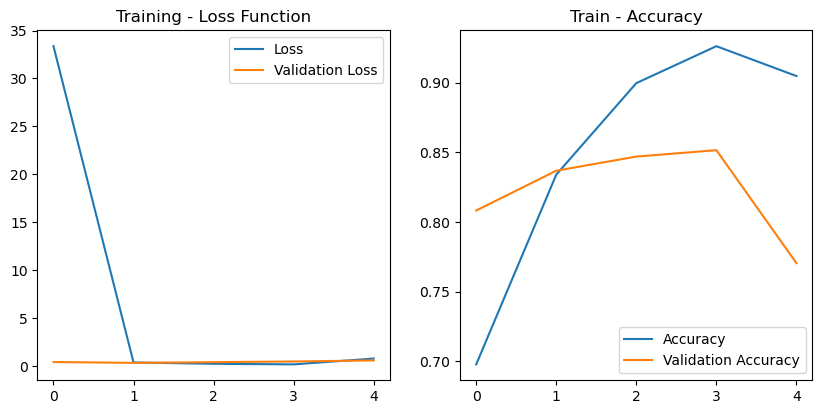

In [33]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history_2.history['loss'], label='Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history_2.history['accuracy'], label='Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

### Over Sampling the Data

In [34]:
# over sampling

from imblearn.over_sampling import SMOTE

x_os = x.reshape(x.shape[0], -1)  # flatten each image to a 1D array

smote = SMOTE()

x_os, y_os = smote.fit_resample(x_os, y)

In [35]:
x_os.shape, x.shape

((20384, 187500), (13808, 250, 250, 3))

In [36]:
#deflatten each image back to its original form

# Assume original shape of each image is (height, width, channels)
height, width, channels = 250, 250, 3

# Reshape flattened data back to original shape
x_os = x_os.reshape(-1, height, width, channels)

# Print the new shape of x_us
print("New shape of x_os:", x_os.shape)

New shape of x_os: (20384, 250, 250, 3)


In [37]:
y_os.shape

(20384,)

In [38]:
unique_values, counts = np.unique(y_os, return_counts=True)
print("Unique values:", unique_values)
print("Counts:", counts)

Unique values: [0 1]
Counts: [10192 10192]


### Splitting the Data

In [39]:
#let us split the train data into test and train
from sklearn.model_selection import train_test_split

x_train2,x_test2,y_train2,y_test2 = train_test_split(x_os,y_os,test_size = 0.25,random_state = 42)

In [40]:
x_train2.shape, y_train2.shape

((15288, 250, 250, 3), (15288,))

In [41]:
x_test2.shape, y_test2.shape

((5096, 250, 250, 3), (5096,))

###### Defining the Model

In [42]:
model_os = Sequential()

model_os.add(Conv2D(64, (3,3), activation='relu', input_shape=(250,250,3)))
model_os.add(MaxPooling2D((2,2)))

model_os.add(Conv2D(32, (3,3), activation='relu'))
model_os.add(MaxPooling2D((2,2)))

model_os.add(Flatten())
model_os.add(Dense(250, activation='relu'))
model_os.add(Dropout(0.2))
model_os.add(Dense(100, activation='relu'))

model_os.add(Dense(1, activation='sigmoid'))

In [43]:
model_os.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 248, 248, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 124, 124, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 122, 122, 32)      18464     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 119072)            0         
                                                                 
 dense_7 (Dense)             (None, 250)              

### Compile & Fit the Model

In [44]:
BATCH_SIZE = 128

# Compile the model
model_os.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta=0.0005, patience=1, mode='auto')

# Generate batches using a generator function for the training set
def data_generator(x, y, batch_size):
    num_samples = len(x)
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    num_batches = num_samples // batch_size

    while True:
        for batch_index in range(num_batches):
            batch_indices = indices[batch_index * batch_size : (batch_index + 1) * batch_size]
            batch_x = x[batch_indices]
            batch_y = y[batch_indices]
            yield batch_x, batch_y

# Create the generator object for the training set
train_generator = data_generator(x_train2, y_train2, BATCH_SIZE)

# Fit the model using the training set generator
history_3= model_os.fit(train_generator, steps_per_epoch=len(x_train2) // BATCH_SIZE, epochs=5, 
                        callbacks=[es], validation_data=(x_test2, y_test2))

2023-05-16 13:29:24.248982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/5
119/119 [==============================] - 3328s 28s/step - loss: 24.4095 - accuracy: 0.8279 - val_loss: 0.2718 - val_accuracy: 0.8858
Epoch 2/5
119/119 [==============================] - 3086s 26s/step - loss: 0.2087 - accuracy: 0.9108 - val_loss: 0.2595 - val_accuracy: 0.8991
Epoch 3/5
119/119 [==============================] - 3249s 27s/step - loss: 0.1519 - accuracy: 0.9343 - val_loss: 0.2758 - val_accuracy: 0.8878


### Evaluating Data

In [55]:
#Evaluating the model
test_loss_im, test_acc_im = model_os.evaluate(x_test2,  y_test2, verbose=2)
print('Test loss with Over Sampling Data is ',test_loss_im)
print('Test Accuracy with Over Sampling Data is ',test_acc_im)

160/160 - 138s - loss: 0.2758 - accuracy: 0.8878 - 138s/epoch - 865ms/step
Test loss with Over Sampling Data is  0.275841623544693
Test Accuracy with Over Sampling Data is  0.8877550959587097


Text(0.5, 1.0, 'Train - Accuracy')

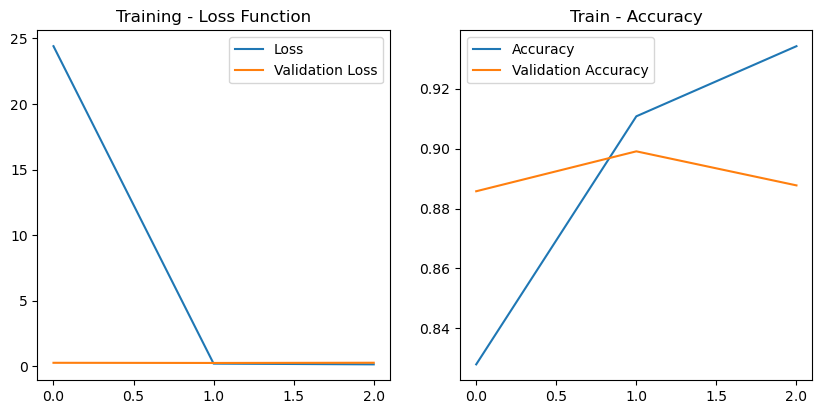

In [47]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history_3.history['loss'], label='Loss')
plt.plot(history_3.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history_3.history['accuracy'], label='Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

### Transfer Learning the Model (VGG16)

In [50]:
from tensorflow.keras.applications.vgg16 import VGG16

In [51]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

58889256/58889256 [==============================] - 68s 1us/step


In [52]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 62, 62, 128)       0     

In [53]:
base_model.trainable=False

model_v16 = Sequential()
model_v16.add(base_model)
model_v16.add(Flatten())
model_v16.add(Dense(128, activation='relu'))
model_v16.add(Dropout(0.5))
model_v16.add(Dense(1, activation='sigmoid'))

In [54]:
model_v16.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_10 (Dense)            (None, 128)               3211392   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 17,926,209
Trainable params: 3,211,521
Non-trainable params: 14,714,688
_________________________________________________________________


### Compile and fit the Model

In [58]:
model_v16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', min_delta=0.005, patience=2, mode='auto')

model_v16.fit(x_train1, y_train1, epochs=10, validation_split=0.25, batch_size=64, callbacks=[es])

Epoch 1/10
64/64 [==============================] - 3846s 61s/step - loss: 2.8780 - accuracy: 0.7109 - val_loss: 0.3242 - val_accuracy: 0.8783
Epoch 2/10
64/64 [==============================] - 3331s 52s/step - loss: 0.3430 - accuracy: 0.8380 - val_loss: 0.2024 - val_accuracy: 0.9299
Epoch 3/10
64/64 [==============================] - 3316s 52s/step - loss: 0.2379 - accuracy: 0.8862 - val_loss: 0.1690 - val_accuracy: 0.9410
Epoch 4/10
64/64 [==============================] - 2530s 40s/step - loss: 0.1868 - accuracy: 0.9051 - val_loss: 0.1592 - val_accuracy: 0.9469
Epoch 5/10
64/64 [==============================] - 2499s 39s/step - loss: 0.1541 - accuracy: 0.9275 - val_loss: 0.1481 - val_accuracy: 0.9491
Epoch 6/10
64/64 [==============================] - 3381s 53s/step - loss: 0.1336 - accuracy: 0.9469 - val_loss: 0.1409 - val_accuracy: 0.9543
Epoch 7/10
64/64 [==============================] - 2796s 44s/step - loss: 0.1231 - accuracy: 0.9417 - val_loss: 0.1338 - val_accuracy: 0.9550

- So we got best accuracy with VGG16 Transfer Learning Model - 95.87% with Over Sampling with 88.77% as second best.